In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

#### Preparation

    Create the target variable by mapping yes to 1 and no to 0.
    Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1.

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


seed = 1
dv = DictVectorizer(sparse=False)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
%matplotlib inline

In [3]:
df = pd.read_csv("AER_credit_card_data.csv")
df.head(2)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [5]:
y = df.pop("card")
y = [1 if i=="yes" else 0 for i in y]

In [6]:
df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=seed)
df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.25, random_state=seed)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

df_train.head(2)

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,3,40.50000,4.0128,0.000299,0.0,no,no,1,12,1,17
1,1,32.33333,6.0000,0.000200,0.0,yes,no,4,18,1,4


In [7]:
X_train = dv.fit_transform(df_train.to_dict(orient="records"))
X_val = dv.transform(df_val.to_dict(orient="records"))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [8]:
numerical_columns = df.columns[df.dtypes != object]
numerical_columns

Index(['reports', 'age', 'income', 'share', 'expenditure', 'dependents',
       'months', 'majorcards', 'active'],
      dtype='object')

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score and compute AUC with the card variable.
    Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [9]:
cols = []
scores = []
for col in df_train[numerical_columns]:
    if col in ["reports", "dependents", "active", "share"]:
        score = round(roc_auc_score(y_train, df_train[col]), 3)
        if score < 0.5:
            score = round(roc_auc_score(y_train, -df_train[col]), 3)
        # print(col, "\t", score)
        cols.append(col)
        scores.append(score)

In [10]:
highest_val_feature, highest_val = max(zip(cols, scores), key=lambda x: x[1])
# print(highest_val)
print(highest_val_feature)

share


#### Q1. Which numerical variable (among the following 4) has the highest AUC?

#### share

Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [11]:
y_val_pred = model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_val_pred)
print(round(score, 3))

0.995


#### Q2. What's the AUC of this model on the validation dataset? (round to 3 digits)

#### 0.995

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

In [12]:
precisions = []
recalls = []
f1s = []
thresholds = np.arange(0.0, 1.0, 0.01)

for threshold in thresholds:
    y_val_pred = (model.predict_proba(X_val)[:, 1]>threshold)
    # print(round(score, 3))
    precision = precision_score(y_val, y_val_pred>threshold)
    recall = recall_score(y_val, y_val_pred>threshold)
    f1 = f1_score(y_val, y_val_pred)
    
    # print(precision, recall)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

In [13]:
df_res = pd.DataFrame({
    "Threshold": thresholds,
    "Precision": precisions,
    "Recall": recalls,
    "F1": f1s
})

In [14]:
# actual_positive = (y_valid == 1)
# actual_negative = (y_valid == 0)
# pred_positive = (y_valid_pred == 1)
# pred_negative = (y_valid_pred == 0)

# tp = (pred_positive & actual_positive).sum()
# tn = (pred_negative & actual_negative).sum()

# fp = (pred_positive & actual_negative).sum()
# fn = (pred_negative & actual_positive).sum()

# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# print(precision, recall)

In [15]:
# plt.plot(df_res.Threshold, df_res.Precision, label='Precision')
# plt.plot(df_res.Threshold, df_res.Recall, label='Recall')
# plt.legend()

In [16]:
# ax = sns.lineplot(x=df_res.Threshold, y=df_res.Precision, color='r', legend=False)
# sns.lineplot(x=df_res.Threshold, y=df_res.Recall, color='b', ax=ax.twinx(), legend=False)
# ax.figure.legend(['Precision', 'Recall'])

<AxesSubplot:xlabel='Threshold'>

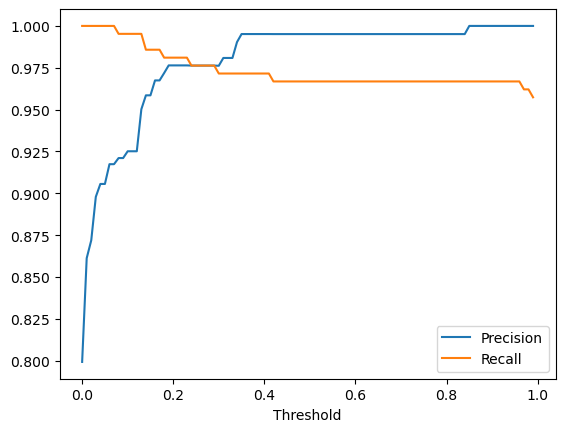

In [17]:
df_res.plot(x="Threshold", y=["Precision", "Recall"])

In [18]:
df_res[df_res.Precision == df_res.Recall].loc[:, ["Threshold", "Precision", "Recall"]]

,Threshold,Precision,Recall
24,0.24,0.976303,0.976303
25,0.25,0.976303,0.976303
26,0.26,0.976303,0.976303
27,0.27,0.976303,0.976303
28,0.28,0.976303,0.976303
29,0.29,0.976303,0.976303


#### Q3. At which threshold precision and recall curves intersect?

#### 0.3 (i.e. From 0.24 to 0.29)

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [19]:
# F1s = []
# for threshold, precision, recall in zip(thresholds, precisions, recalls):
#     F1 = 2 * (precision * recall) / (precision + recall)
#     F1s.append(F1)
    
# list(zip(thresholds, F1s))

In [20]:
df_res[df_res.F1==df_res.F1.max()].loc[:, ["Threshold", "F1"]]

,Threshold,F1
35,0.35,0.983213
36,0.36,0.983213
37,0.37,0.983213
38,0.38,0.983213
39,0.39,0.983213
40,0.40,0.983213
41,0.41,0.983213


#### Q4. At which threshold F1 is maximum?

#### 0.4 (i.e. from 0.35 to 0.41)

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation

In [21]:
def auc_score(X, y, c=1.0):
    scores = []
    y = pd.Series(y)
    
    for train_idx, val_idx in kfold.split(X=X, y=y):    
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_val, y_val = X.iloc[val_idx], y[val_idx]

        X_train = dv.fit_transform(X_train.to_dict(orient="records"))
        X_val = dv.transform(X_val.to_dict(orient="records"))

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=seed)
        model.fit(X_train, y_train)

        y_val_pred = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_val_pred)

        # print(score)
        scores.append(score)
        
    return scores

In [22]:
scores = auc_score(df_train, y_train)

print(np.std(scores))

0.003108591415706826


#### Q5. How large is standard devidation of the AUC scores across different folds?

#### 0.003

Now let's use 5-Fold cross-validation to find the best parameter C

    Iterate over the following C values: [0.01, 0.1, 1, 10]
    Initialize KFold with the same parameters as previously
    Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


In [23]:
mean_scores = []
Cs = [0.01, 0.1, 1, 10]
for c in Cs:
    scores = auc_score(df_train, y_train, c=c)
    mean_score = round(np.mean(scores), 3)
    std_score = round(np.std(scores), 3)
    
    mean_scores.append(mean_score)
    
    print("C :", c)
    print(mean_score, std_score)

C : 0.01
0.992 0.006
C : 0.1
0.995 0.004
C : 1
0.996 0.003
C : 10
0.996 0.004


In [24]:
max_mean_score = max(mean_scores)

best_mean_cs = []
for mean_score, c in zip(mean_scores, Cs):
    if mean_score == max_mean_score:
        best_mean_cs.append(c)

min(best_mean_cs)
# print(max(zip(mean_scores, Cs)))

1

#### Q6. Which C leads to the best mean score?
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

#### 1